In [ ]:
import yfinance as yf
import pandas as pd
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import date
from dateutil.relativedelta import relativedelta

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Optimized Portfolio Weights (Min Volatility):
SPY: 0.1867
VOO: 0.0000
SCHD: 0.8133
VTI: 0.0000
QQQ: 0.0000
Sum of Optimized Weights: 1.0000


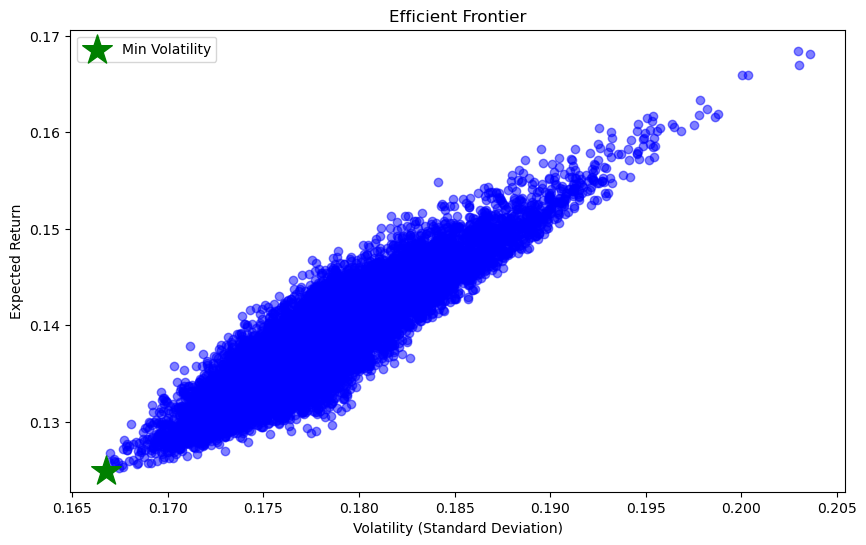


Optimal Weights for Minimum Volatility Portfolio:
SPY     0.058658
VOO     0.070622
SCHD    0.788139
VTI     0.043706
QQQ     0.038875
dtype: float64


In [94]:

import yfinance as yf
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Download data function
def download_data(ticker_symbols, start_date,  end_date):
        data = {}
        for symbol in ticker_symbols:
                symbol_data = yf.download(symbol, start=start_date, end=end_date)
                data[symbol] = symbol_data['Adj Close']
        symbol_prices = pd.DataFrame(data)
        return symbol_prices

# returns annualized return percentage
def calculate_annualized_returns(ticker_data):
    daily_returns = ticker_data.pct_change().dropna()
    annualized_returns = daily_returns.mean() * 252  # 252 trading days in a year
    return annualized_returns


# returns covariance matrix
def calculate_annualized_covariance(ticker_data):
    daily_returns = ticker_data.pct_change().dropna()
    annualized_covariance = daily_returns.cov() * 252
    return annualized_covariance

# returns a portfolio's returns and standard deviation given a specific weight
def portfolio_performance(weights, returns, covariance_matrix):
    # return = sum of weights*returns
    portfolio_return = np.sum(returns * weights)
    # standard deviations = sqrt(variance) = sqrt(weights.T * covariance * weights) 
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    return portfolio_return, portfolio_std_dev

def optimize_portfolio(returns, covariance_matrix):
    num_tickers = len(returns)
    args = (returns, covariance_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Sum of weights must equal 1
    bounds = tuple((0, 1) for i in range(num_tickers))  # Weight bounds (0 to 1)

    # Initial guess for equal weights
    initial_weights = num_tickers * [1. / num_tickers]
    def vol_function(weights):
          return portfolio_performance(weights, returns, covariance_matrix)[1]

    result = minimize(vol_function, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# Function to calculate the efficient frontier
def efficient_frontier(returns, covariance_matrix, num_portfolios=10000):
    results = np.zeros((2, num_portfolios))
    weights_record = []
    
    num_tickers = len(returns)
    
    for i in range(num_portfolios):
        # generate random weights
        weights = np.random.random(num_tickers)
        # Ensure weights sum to 1
        weights /= np.sum(weights)  
        portfolio_return, portfolio_std_dev = portfolio_performance(weights, returns, covariance_matrix)
        
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return

        weights_record.append(weights)
        
    return results, weights_record

# Function to plot the efficient frontier
def plot_efficient_frontier(results, min_vol_idx, weights_record, tickers):
    plt.figure(figsize=(10, 6))
    plt.scatter(results[0, :], results[1, :], c='blue', marker='o', alpha=0.5)
    plt.scatter(results[0, min_vol_idx], results[1, min_vol_idx], marker='*', color='g', s=500, label='Min Volatility')

    plt.title('Efficient Frontier')
    plt.xlabel('Volatility (Standard Deviation)')
    plt.ylabel('Expected Return')
    plt.legend()
    plt.show()

    # Display the optimal weights for the minimum volatility portfolio
    print("\nOptimal Weights for Minimum Volatility Portfolio:")
    print(pd.Series(weights_record[min_vol_idx], index=tickers))


def main():
    # Step 1: Get ETF Symbols and Download Data
    # pre-defined list of top 50 ETFs symbols by AUM
        etfs = ['SPY', 'VOO', 'SCHD', 'VTI', 'QQQ']
        present_date = date.today()
        past_date = present_date - relativedelta(years=10)
        present_date = present_date.strftime('%Y-%m-%d')
        past_date = past_date.strftime('%Y-%m-%d')
        etf_data = download_data(etfs, past_date, present_date)
        prices = pd.DataFrame(etf_data)

        # Calculate annualized returns and covariance
        annualized_returns = calculate_annualized_returns(prices)
        annualized_covariance = calculate_annualized_covariance(prices)

        
        # Optimize the portfolio
        optimized_portfolio = optimize_portfolio(annualized_returns, annualized_covariance)

        # Display the optimized portfolio weights
        optimized_weights = optimized_portfolio.x
        print("Optimized Portfolio Weights (Min Volatility):")
        for etf, weight in zip(etfs, optimized_weights):
            print(f"{etf}: {weight:.4f}")

        # Calculate and display the sum of the optimized weights
        weights_sum = np.sum(optimized_weights)
        print(f"Sum of Optimized Weights: {weights_sum:.4f}")

        # Equal weights for comparison
        equal_weights = np.array([1 / len(etfs)] * len(etfs))  # Equal weights for all ETFs

        # Performance of the optimized portfolio
        opt_return, opt_std_dev = portfolio_performance(optimized_weights, annualized_returns, annualized_covariance)

        # Performance of the equally weighted portfolio
        eq_return, eq_std_dev = portfolio_performance(equal_weights, annualized_returns, annualized_covariance)

        # Print the comparison between optimized and equal weights portfolios
        print("\nComparison of Optimized vs Equal Weights Portfolio:")
        print(f"Optimized Portfolio - Return: {opt_return:.4f}, Volatility: {opt_std_dev:.4f}")
        print(f"Equal Weights Portfolio - Return: {eq_return:.4f}, Volatility: {eq_std_dev:.4f}")

        # Efficient frontier and random portfolios
        results, weights_record = efficient_frontier(annualized_returns, annualized_covariance)

        # Find the index of the portfolio with the minimum volatility
        min_vol_idx = np.argmin(results[0])

        # Plot the efficient frontier and show the minimum volatility portfolio
        plot_efficient_frontier(results, min_vol_idx, weights_record, etfs)


        
    
# risk = weights*covariance matrix * weights.T
# returns = returns vector * weights.T or by dot product
# min risk and max
# point on the curve of efficiency w = lambda * (covariance^-1) * return vectors

if __name__ == "__main__":
    main()


In [ ]:
# testing with personal ticker symbols
voo_data = yf.download('VOO', start=past_date, end=present_date)
schd_data = yf.download('SCHD', start=past_date, end=present_date)
data={}
data['VOO'] = voo_data['Adj Close']
data['SCHD'] = schd_data['Adj Close']
prices = pd.DataFrame(data)
prices.plot()
plt.title("ETF Prices")
plt.legend()
plt.show()

In [ ]:
# function to calculate annual returns of dataframe consisting of
# ticker symbols and adj closing prices
def calculate_annual_returns(prices):
    # percent changes in daily returns
    daily_returns = prices.pct_change().dropna()

    # find the average daily return then multiply by 252 (trading days in a year)
    annual_returns = daily_returns.mean() * 252
    return annual_returns

# # testing with above price dataframe
# annual_returns = calculate_annual_returns(prices)
# annual_returns



In [ ]:
# function to download the financial data of ticker symbols from yf
# parameters = symbol names, start date, end date
def download_fin_data(symbols, s_date, e_date):
    data = []
    for s in symbols:
        symbol_data = yf.download(s, start=s_date, end=e_date)
        data[s] = symbol_data['Adj Close']
